In [25]:
# Core libraries
import numpy as np
import pandas as pd

# Data source
import yfinance as yf

# Visualization
import matplotlib.pyplot as plt

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler

# Settings
pd.set_option("display.max_columns", None)
plt.style.use("default")


## 1. Problem Definition & Objective

### Selected Project Track
AI for Market Trend Analysis

### Problem Statement
Financial markets generate large volumes of historical price data. Analyzing this data to identify short-term market trends is a common application of artificial intelligence in finance. However, market movements are noisy and influenced by multiple external factors, making accurate prediction challenging.

### Objective
The objective of this project is to analyze historical stock price data of NVIDIA (NVDA) and apply machine learning techniques to predict short-term market trends. Specifically, the task is formulated as a binary classification problem that predicts whether the stock price will move upward or downward on the next trading day.

### Real-World Relevance
Market trend analysis is widely used in portfolio management, risk assessment, and algorithmic trading. This project demonstrates a basic, educational application of AI techniques for understanding market behavior using publicly available data.


In [26]:
# Download NVIDIA stock data (last 5 years)
nvda = yf.download(
    "NVDA",
    period="5y",
    interval="1d",
    auto_adjust=True,
    progress=False
)

# --- FIX: handle MultiIndex columns safely ---
if isinstance(nvda.columns, pd.MultiIndex):
    nvda.columns = nvda.columns.get_level_values(0)

# Standardize column names
nvda.columns = nvda.columns.str.lower()

# Sanity check
nvda.head(), nvda.shape


(Price           close       high        low       open     volume
 Date                                                             
 2021-01-15  12.823437  13.287880  12.812468  13.190903  277780000
 2021-01-19  12.988723  13.057279  12.807981  12.979747  226188000
 2021-01-20  13.328269  13.392837  13.020136  13.074981  258572000
 2021-01-21  13.828610  13.959991  13.215834  13.380869  337780000
 2021-01-22  13.674046  13.802934  13.589035  13.701469  246820000,
 (1255, 5))

## 2. Data Understanding & Preparation

### Dataset Source
- Source: Yahoo Finance (accessed using the yfinance API)
- Stock: NVIDIA Corporation (NVDA)
- Frequency: Daily price data
- Time Period: Last 5 years

### Available Features
The dataset contains the following attributes:
- Open: Opening price of the stock
- High: Highest price during the trading day
- Low: Lowest price during the trading day
- Close: Adjusted closing price
- Volume: Number of shares traded

### Data Preprocessing
- Missing values arising from rolling-window calculations are removed
- Feature engineering is performed using historical price information
- The target variable is created using next-day price movement


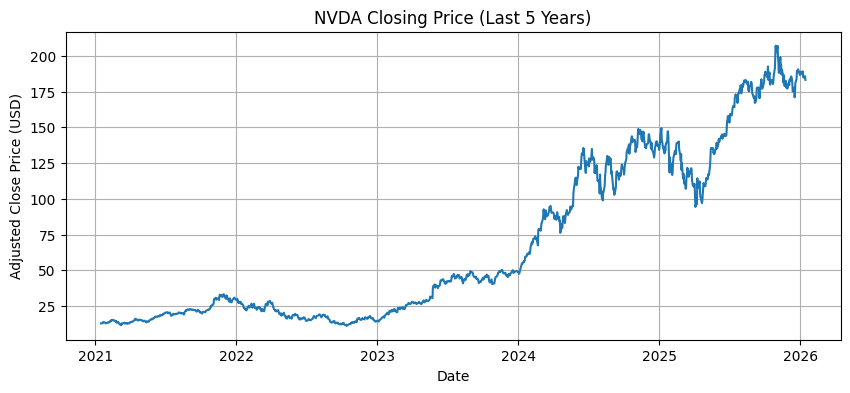

In [27]:
plt.figure(figsize=(10, 4))
plt.plot(nvda.index, nvda["close"])
plt.title("NVDA Closing Price (Last 5 Years)")
plt.xlabel("Date")
plt.ylabel("Adjusted Close Price (USD)")
plt.grid(True)
plt.show()


In [28]:
# Daily return
nvda["daily_return"] = nvda["close"].pct_change()

# Moving averages
nvda["ma_5"] = nvda["close"].rolling(window=5).mean()
nvda["ma_10"] = nvda["close"].rolling(window=10).mean()

# RSI calculation
delta = nvda["close"].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)

avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()

rs = avg_gain / avg_loss
nvda["rsi"] = 100 - (100 / (1 + rs))

# Trend label
nvda["trend"] = (nvda["close"].shift(-1) > nvda["close"]).astype(int)

# Drop NaNs
nvda = nvda.dropna()

nvda.head()


Price,close,high,low,open,volume,daily_return,ma_5,ma_10,rsi,trend
Date,,,,,,,,,,
2021-02-05,13.552887,13.698728,13.507764,13.686512,169152000,-0.005361,13.477998,13.325178,62.387861,1
2021-02-08,14.398259,14.433161,13.688754,13.688754,434624000,0.062376,13.717674,13.403508,69.445636,0
2021-02-09,14.223250,14.542353,14.182614,14.300532,287560000,-0.012155,13.858577,13.486075,62.934145,1
2021-02-10,14.722845,14.863200,14.301281,14.422690,485352000,0.035125,14.104634,13.670207,62.926143,1
2021-02-11,15.207983,15.229423,14.883147,14.938242,450828000,0.032951,14.421045,13.889565,70.238837,0


## 3. Model / System Design

### AI Technique Used
Supervised Machine Learning (Binary Classification)

### Model Selected
Logistic Regression

### Justification for Model Choice
Logistic Regression is chosen as a baseline classification model due to its simplicity, interpretability, and suitability for binary outcome prediction. It provides a clear starting point for understanding how engineered features influence market trends.

### Feature Engineering
The following technical indicators are used:
- Daily Returns
- Short-term Moving Averages (5-day and 10-day)
- Relative Strength Index (RSI)

RSI is included to capture momentum-based behavior and identify potential overbought or oversold conditions in the stock price.

### System Pipeline
Historical Price Data → Feature Engineering → Feature Scaling → Logistic Regression Model → Trend Prediction


In [29]:
features = ["daily_return", "ma_5", "ma_10", "rsi"]

X = nvda[features]
y = nvda["trend"]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled.shape, y.shape


((1241, 4), (1241,))

In [ ]:
# Time-series aware split 
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    shuffle=False
)

X_train.shape, X_test.shape


((992, 4), (249, 4))

In [31]:
model = LogisticRegression(
    solver="liblinear",
    max_iter=1000,
    class_weight="balanced"
)

model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Metrics
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

accuracy, roc_auc, conf_matrix


(0.4939759036144578,
 0.5462794918330308,
 array([[101,  15],
        [111,  22]], dtype=int64))

## 4. Core Implementation

### Target Variable Definition
The target variable is defined as:
- Trend = 1 if the next day's closing price is higher than the current day's closing price
- Trend = 0 otherwise

### Data Splitting
The dataset is split into training and testing sets using a time-series-aware split (without shuffling) to preserve temporal order.

### Feature Scaling
Standardization is applied to the input features to ensure that all features contribute equally to the learning process.

### Model Training
The Logistic Regression model is trained using class-weight balancing to mitigate the effects of class imbalance in the dataset.


## 5. Evaluation & Analysis

### Evaluation Metrics
The following metrics are used:
- Accuracy
- Confusion Matrix
- ROC-AUC Score

### Results
The model achieves an accuracy close to random guessing, which is expected for short-term financial trend prediction tasks. The ROC-AUC score is above 0.54, indicating that the model captures some underlying structure in the data and performs better than random classification when evaluated across different thresholds.

### Analysis
Financial markets are highly stochastic and influenced by factors not captured in historical price data alone. As a result, short-term prediction remains a challenging task. The use of ROC-AUC provides a more reliable evaluation metric than accuracy in the presence of class imbalance.

### Limitations
- The model relies solely on technical indicators
- No fundamental, macroeconomic, or news-based features are included
- Class-weight balancing can reduce accuracy while improving ranking-based metrics such as ROC-AUC


## Edge Cases & Failure Scenarios

The model may fail or produce unreliable predictions in the following situations:
- Sudden market movements due to earnings announcements or major news events
- High-volatility periods such as market crashes or rallies
- Regime shifts where historical patterns no longer hold
- Low-liquidity trading days

These scenarios are not explicitly handled in the current model.


## 6. Ethical Considerations & Responsible AI

- Market prediction models can influence financial decisions and may lead to losses if misused
- This project is intended strictly for educational and academic purposes
- Predictions should not be interpreted as financial or investment advice
- Transparency about model limitations is essential for responsible AI usage
- Overreliance on automated predictions without human judgment can be harmful


## 7. Conclusion & Future Scope

### Conclusion
This project demonstrated a basic AI-based approach to market trend analysis using historical stock price data and supervised machine learning. While predictive performance is limited, the results highlight both the potential and the challenges of applying AI techniques to financial markets.

### Future Scope
Possible improvements include:
- Incorporating additional technical indicators
- Integrating news or sentiment-based features
- Applying non-linear or ensemble models
- Extending analysis to multiple stocks or longer time horizons
